In [ ]:
!pip install tensorflow
import os
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, Dropout, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Load dataset
df = pd.read_csv('/content/UpdatedResumeDataSet.csv')
df

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


<ipython-input-9-24b70a8518fb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  customization = sns.countplot(data=df, x="Category", palette="Set1")


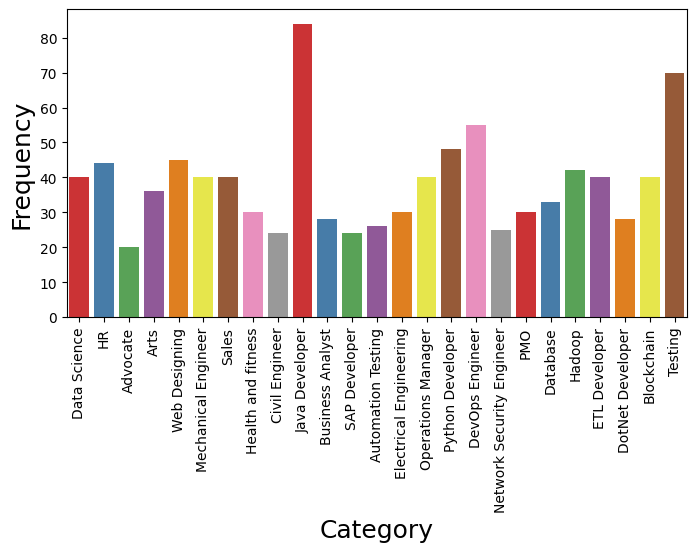

In [ ]:
plt.figure(figsize=(8, 4))
customization = sns.countplot(data=df, x="Category", palette="Set1")
customization.set_xlabel("Category", fontsize = 18)
customization.set_ylabel("Frequency", fontsize = 18)
plt.xticks(rotation=90)
plt.show()

<ipython-input-11-3477cc7b4018>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['length']).set_title('Resume length distribution')


Text(0.5, 1.0, 'Resume length distribution')

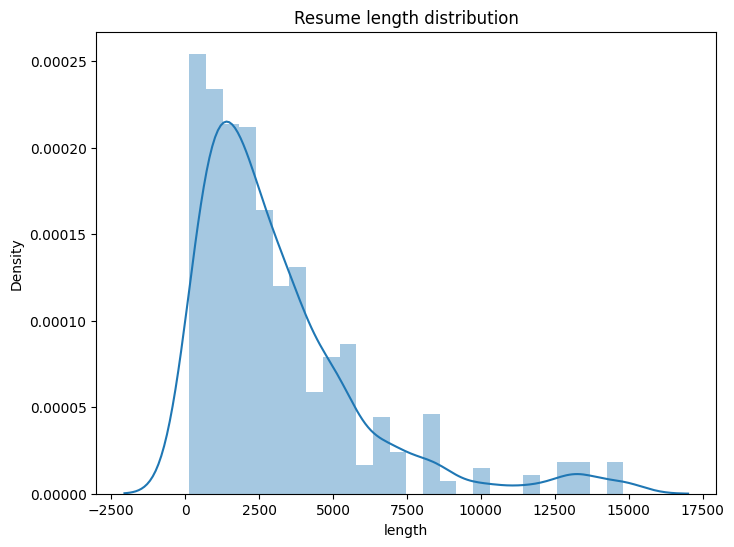

In [ ]:
df['length'] = df['Resume'].str.len()
plt.figure(figsize=(8,6))
sns.distplot(df['length']).set_title('Resume length distribution')

In [ ]:
# Preprocessing
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z ]", "", text)
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words and len(word) > 2])
    return text

df['Cleaned_Resume'] = df['Resume'].apply(clean_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Cleaned_Resume'])
X_seq = tokenizer.texts_to_sequences(df['Cleaned_Resume'])
X_pad = pad_sequences(X_seq)

In [ ]:
# Encode target variable
le = LabelEncoder()
y = le.fit_transform(df['Category'])
y_cat = to_categorical(y)

In [ ]:
# Train-test-validation split
X_train_full, X_test, y_train_full, y_test = train_test_split(X_pad, y_cat, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=np.argmax(y_train_full, axis=1), random_state=42)

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
callbacks = [early_stop, reduce_lr]



In [ ]:
# CNN Model
from tensorflow.keras.layers import BatchNormalization, Activation
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=X_pad.shape[1]))
model.add(Conv1D(128, kernel_size=5))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_cat.shape[1], activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=64, verbose=1, callbacks=callbacks)

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.0314 - loss: 3.6532 - val_accuracy: 0.1931 - val_loss: 3.2065 - learning_rate: 0.0010
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1059 - loss: 3.1282 - val_accuracy: 0.1485 - val_loss: 3.2013 - learning_rate: 0.0010
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2203 - loss: 2.9286 - val_accuracy: 0.2475 - val_loss: 3.1933 - learning_rate: 0.0010
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3095 - loss: 2.6060 - val_accuracy: 0.4505 - val_loss: 3.1712 - learning_rate: 0.0010
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4031 - loss: 2.2407 - val_accuracy: 0.6436 - val_loss: 3.1402 - learning_rate: 0.0010
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5927 - loss: 1.7683 - val_accuracy: 0.6931 - val_loss: 3.0956 - learning_rate: 0.0010
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7300 - loss: 1.3060 - val_accuracy: 0.8218 

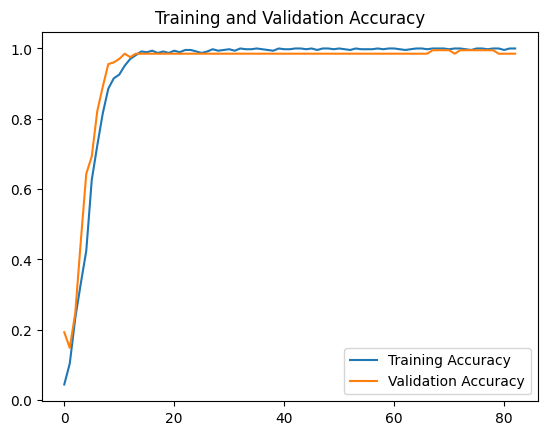

In [ ]:
# Accuracy & Loss plots
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

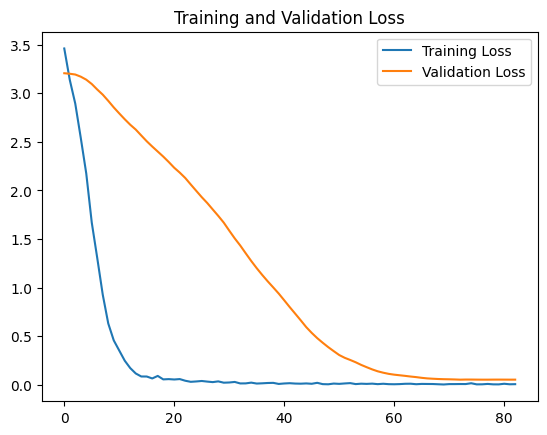

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Final evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9809 - loss: 0.1359
Test Accuracy: 0.9792


In [ ]:
model.save('resume_cnn_model_2.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/resume_cnn_model_2.h5')

# for loading
# from keras.models import load_model
# model = load_model('/content/drive/MyDrive/resume_cnn_model_2.h5')

Mounted at /content/drive
